<a href="https://colab.research.google.com/github/itcxx/Notebook/blob/main/%E7%9B%AE%E6%A0%87%E6%A3%80%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 目标检测和边界框



In [ ]:
%matplotlib inline
from PIL import Image
from google.colab import drive
drive.mount('/content/drive/')

import os
current_directory=os.getcwd()
print(current_directory)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content


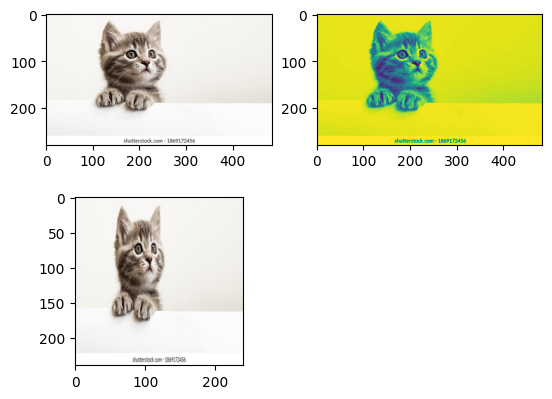

In [34]:
img=Image.open("/content/drive/MyDrive/Colab Notebooks/DL/cat.jpg")
import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
# 转换成灰度图片
img_gray=img.convert('L')
plt.imshow(img_gray)
# 改变大小
plt.subplot(223)
img_resize=img.resize((240,240))
plt.imshow(img_resize)



# 锚框
在⽬标检测⾥，我们通常使⽤边界框（bounding box）来描述⽬标位置。边界框是⼀个矩形框，可以由矩形左上⻆的轴坐标与右下⻆的轴坐标确定
# 새 섹션

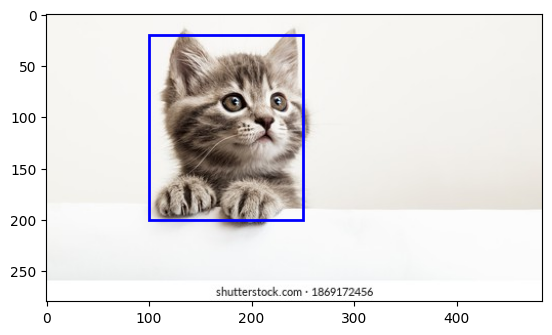

In [35]:
# 边缘框的绘制
def bbox_to_rect(bbox,color):
    #将边界框（左上x,左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, ⾼)
    return plt.Rectangle((bbox[0],bbox[1]),width=bbox[2]-bbox[0],height=bbox[3]-bbox[1],
                        fill=False,edgecolor=color,linewidth=2)


# 我们将边界框加载在图像上，可以看到⽬标的主要轮廓基本在框内。
fig=plt.imshow(img)
fig.axes.add_patch(bbox_to_rect([100,20,250,200],'blue'))

# 多个锚框的生成

假设输入图像的高度为$h$，宽度为$w$。
我们以图像的每个像素为中心生成不同形状的锚框：*缩放比*为$s\in (0, 1]$，*宽高比*为$r > 0$。
那么[**锚框的宽度和高度分别是$hs\sqrt{r}$和$hs/\sqrt{r}$。**]
请注意，当中心位置给定时，已知宽和高的锚框是确定的。

要生成多个不同形状的锚框，让我们设置许多缩放比（scale）取值$s_1,\ldots, s_n$和许多宽高比（aspect ratio）取值$r_1,\ldots, r_m$。
当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有$whnm$个锚框。
尽管这些锚框可能会覆盖所有真实边界框，但计算复杂性很容易过高。
在实践中，(**我们只考虑**)包含$s_1$或$r_1$的(**组合：**)

(**
$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$
**)

也就是说，以同一像素为中心的锚框的数量是$n+m-1$。
对于整个输入图像，将共生成$wh(n+m-1)$个锚框。

上述生成锚框的方法在下面的`multibox_prior`函数中实现。
我们指定输入图像、尺寸列表和宽高比列表，然后此函数将返回所有的锚框。


In [37]:
#$save
def multibox_prior(data,sizes,ratios):
        in_height, in_width = data.shape[-2:]
        device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
        boxes_per_pixel = (num_sizes + num_ratios - 1)
        size_tensor = torch.tensor(sizes, device=device)
        ratio_tensor = torch.tensor(ratios, device=device)

        # 为了将锚点移动到像素的中心，需要设置偏移量。
        # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
        offset_h, offset_w = 0.5, 0.5
        steps_h = 1.0 / in_height  # 在y轴上缩放步长
        steps_w = 1.0 / in_width  # 在x轴上缩放步长

        # 生成锚框的所有中心点
        center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
        center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
        shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
        shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

        # 生成“boxes_per_pixel”个高和宽，
        # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
        w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                       sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                       * in_height / in_width  # 处理矩形输入
        h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                       sizes[0] / torch.sqrt(ratio_tensor[1:])))
        # 除以2来获得半高和半宽
        anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                            in_height * in_width, 1) / 2

        # 每个中心点都将有“boxes_per_pixel”个锚框，
        # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
        out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                    dim=1).repeat_interleave(boxes_per_pixel, dim=0)
        output = out_grid + anchor_manipulations
        return output.unsqueeze(0)

返回的锚框变量Y的形状是： (批量大小，锚框的数量，4） ： 4为左上和右下的两点坐标

In [39]:
from PIL import Image
import torch
img=Image.open("/content/drive/MyDrive/Colab Notebooks/DL/cat.jpg")
print(img.size)
h , w=img.size[:2]
print(h,w)

X=torch.rand(size=(1,3,h,w))   #随机生成一个 【1，3，h,W ] 的矩阵
Y=multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape  #大小=484*280*5，4

(484, 280)
484 280


torch.Size([1, 677600, 4])

将锚框变量`Y`的形状更改为(图像高度,图像宽度,以同一像素为中心的锚框的数量,4)后，我们可以获得以指定像素的位置为中心的所有锚框。
在接下来的内容中，我们[**访问以（250,250）为中心的第一个锚框**]。
它有四个元素：锚框左上角的$(x, y)$轴坐标和右下角的$(x, y)$轴坐标。
输出中两个轴的坐标各分别除以了图像的宽度和高度。

In [40]:
boxes=Y.reshape(h,w,5,4)
boxes[250,250,0,:]

tensor([0.2464, 0.1426, 1.5429, 0.8926])

为了[显示以图像中以某个像素为中心的所有锚框]，定义下面的show_bboxes函数来在图像上绘制多个边界框。

In [42]:

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

正如从上面代码中所看到的，变量boxes中𝑥轴和𝑦轴的坐标值已分别除以图像的宽度和高度。 绘制锚框时，我们需要恢复它们原始的坐标值。 因此，在下面定义了变量bbox_scale。 现在可以绘制出图像中所有以(200,150)为中心的锚框了。 如下所示，缩放比为0.75且宽高比为1的蓝色锚框很好地围绕着图像中的狗。

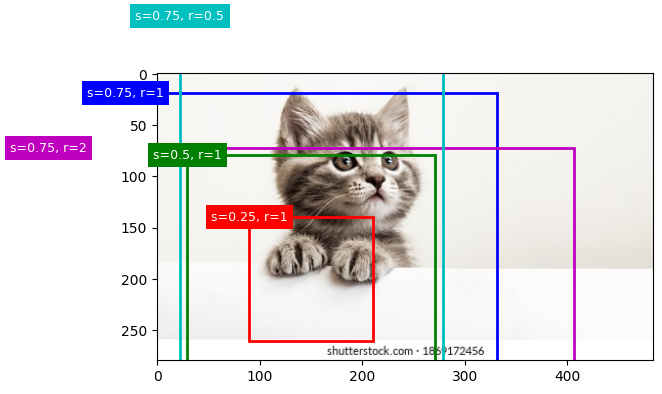

In [43]:
bbox_scale=torch.tensor((w,h,w,h))
fig=plt.imshow(img)
show_bboxes(fig.axes,boxes[200,150,:,:]*bbox_scale,
           ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])